In [ ]:
#一些常用的命令
!nvidia-smi

In [ ]:
#一些常用的命令
!git status
!git add .
!git commit -m "correct and optimize some code"
!git push

0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍
0.这是简化程序，原始带有更多测试和原始模型的程序在mainTestCSVMLP3(hmcnf_keras).ipynb
0.这是简化程序，只训练和测试5label模型,编号为0


Using TensorFlow backend.


0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍
reading data france,读取数据并且把数据进行onehot处理
x0.shape: (680325, 48) y0.shape: (680325,) y0.type: <class 'numpy.ndarray'>
将样本进行处理并且分层
原始样本分为3210和4两类
3210样本分为210和3两类
x.shape: (544260, 48) y.shape: (544260,) y.type: <class 'numpy.ndarray'>
210样本分为10和2两类
x.shape: (408195, 48) y.shape: (408195,) y.type: <class 'numpy.ndarray'>
[10 10 10 ...  2  2  2]
10样本分为0和1两类
x.shape: (272130, 48) y.shape: (272130,) y.type: <class 'numpy.ndarray'>
[0 0 0 ... 1 1 1]
准备字典，用于保存训练后的数据
5label 模型
x.shape: (680325, 48) y.shape: (680325,) y.type: <class 'numpy.ndarray'>
y.shape: (680325, 1) y.type: <class 'numpy.ndarray'>
keras

mat1num
 [[132825   2085    206    192    757]
 [   274 133262   1785    608    136]
 [     0   1131 134146    212    576]
 [     0    272   1040 132694   2059]
 [    33    585   1187    356 133904]]
mat2acc
 [[0.998 0.015 0.001 0.001 0.006]
 [0.002 0.97  0.013 0.005 0.001]
 [0.    0.008 0.97  0.002 0.004]
 [0.    0.002 0.008 0.99  0.015]
 [0

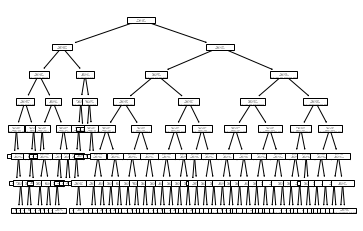

In [3]:
########################################################################################################################
print("0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍")
print("0.这是简化程序，原始带有更多测试和原始模型的程序在mainTestCSVMLP3(hmcnf_keras).ipynb")
print("0.这是简化程序，只训练和测试5label模型,编号为0")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler



########################################################################################################################
#######开始为功能函数
#######函数用于决策树分析

def dtFitAndSave(x,y,saveName):
    str1="dtFitAndSave,用于决策树拟合和识别"
    
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_leaf=100)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    #data=tree.export_graphviz(dt, out_file=None,class_names=None,filled=True) 
    #graph = graphviz.Source(data)
    #graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print("纯决策树的识别\n",tmp1)
    mat1num = confusion_matrix(y,yPredict)
    mat2acc = confusion_matrix(y,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    #text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    return dt,yPredict

########################################################################################################################
###简单模型3，resnet_like

def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model

def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

def kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName):
    str1="kerasFitAndSaveSimple3LikeResnet,用于resnet_like的神经网络拟合和识别"
    
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    hierarchy = [1,1,1]#三层，对于当前数据集已经足够了
    global_models = []
    label_size = num_labels
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

    p_glob = sigmoid_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    
    #build_model = keras.models.load_model(saveName)
    #build_model.fit([x],[yOneHot],epochs=10, batch_size=10000*1)
    build_model.fit(x,yOneHot,epochs=15000, batch_size=20000*1)#GPU用这个
    #saveName = "KerasSimple3_likeResnet.h5"
    build_model.save(saveName)
    #plot_model(build_model, to_file='KerasSimple3_likeResnet.png', show_shapes=True)
    return build_model
########################################################################################################################
def getKerasResnetRVL(x,enc,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    y= model.predict([x], batch_size=2560)
    nSamples = y.shape[0]
    ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(y.shape[0]):
        tmp = y[i]
        index=  np.argmax(tmp)
        y[i] = [0]*y.shape[1]
        y[i,index]=1
   

    ###  
    y= enc.inverse_transform(y)
    y= y.reshape(-1,nSamples)[0]
    
    
    return y
########################################################################################################################
########################################################################################################################
print("0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍")
########################################################################################################################

print("reading data france,读取数据并且把数据进行onehot处理")
file1 = "./trainData/france_0_allSamples1.csv"

xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)
h,w = xyData.shape
#x = xyData[:,1:23]#简单处理与SUMO数据库一致
x0rigin = xyData[:,1:w-1]#用所有的数据
y0rigin  = xyData[:,w-1]
x0rigin =x0rigin.astype(np.float32)#GPU 加这个
y0rigin =y0rigin.astype(np.int64)#GPU 加这个


ros = RandomOverSampler(random_state=0)
x0,y0= ros.fit_resample(x0rigin , y0rigin)#对数据不平衡进行处理，保证样本数一致

x0=x0.astype(np.float32)#GPU 加这个
y0=y0.astype(np.int64)#GPU 加这个
yl5 = y0
print("x0.shape:",x0.shape,"y0.shape:",y0.shape,"y0.type:", type(y0) )
del xyDataTmp #节省内存
del xyData #节省内存

########################################################################################################################
print("将样本进行处理并且分层")
##################################
print("原始样本分为3210和4两类")
index0 = np.where( (yl5 == 3)|(yl5 == 2) | (yl5 == 1) | (yl5 == 0))
index1 = np.where( (yl5 ==4))
x3210_4 = x0.copy()
y3210_4 = yl5.copy()
y3210_4[index0] = 3210

#计算下层标记210,3,4,
y5LabelFloor1 = yl5.copy()



##################################
print("3210样本分为210和3两类")
index0 = np.where( (yl5 == 2) | (yl5 == 1) | (yl5 == 0))
index1 = np.where( (yl5 ==3))

xTmp = x0[index0]
yTmp = yl5[index0]
yTmp[:] = 210

x = np.concatenate((xTmp,x0[index1]),axis=0)
y = np.concatenate((yTmp,yl5[index1]),axis=0)
x210_3 = x
y210_3 = y
print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )



##################################
print("210样本分为10和2两类")
index0 = np.where((yl5 == 1) | (yl5 == 0))
index1 = np.where( (yl5 ==2))
xTmp = x0[index0]
yTmp = yl5[index0]
yTmp[:] = 10

x = np.concatenate((xTmp,x0[index1]),axis=0)
y = np.concatenate((yTmp,yl5[index1]),axis=0)
x10_2 = x
y10_2 = y
print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
print(y10_2)


##################################
print("10样本分为0和1两类")
index0 = np.where( (yl5 == 0))
index1 = np.where( (yl5 ==1))
xTmp = x0[index0]
yTmp = yl5[index0]

x = np.concatenate((xTmp,x0[index1]),axis=0)
y = np.concatenate((yTmp,yl5[index1]),axis=0)

x1_0 = x
y1_0 = y
print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
print(y1_0)

########################################################################################################################
print("准备字典，用于保存训练后的数据")

xFloors=  dict()
yFloors =  dict()
dtModeFloors=  dict()
dtPredictLabel = dict()
kerasPredictLabel = dict()
kerasModelNameFloors =dict()
encFloors= dict()
########################################################################################################################
###现在暂时不训练多层模型，只训练5label模型
if 1:
    print("5label 模型")
    x=x0
    y=yl5
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    
    num_labels = 5 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    saveName = "hybrid2_KerasSimple3_likeResnet_5label.h5"
    if 0:
        kerasModel3_5label = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
    yKeras_5label=getKerasResnetRVL(x,enc,saveName)
    
    print('keras\n')
    mat1num = confusion_matrix(y, yKeras_5label)
    mat2acc = confusion_matrix(y, yKeras_5label,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
    
    
    
    
    dt_5label,dt_PredictLabel = dtFitAndSave(x,yl5,"5label")
    enc_5label = enc
    
    xFloors[0] =  x.copy()
    yFloors[0] =  y.copy()
    dtModeFloors[0] =  dt_5label
    dtPredictLabel[0] = dt_PredictLabel.copy()
    kerasPredictLabel[0] = yKeras_5label.copy()
    kerasModelNameFloors[0] =saveName
    encFloors[0] = enc_5label


In [1]:
########################################################################################################################
print("1.接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率")
print("2.对较低概率的样本进行蒙特卡洛模拟分析，原始对应程序为mainSimSumoFranceDatra")
print("3.程序编号为1")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler
from runSumoSimFun import simSumoCmd
import warnings
warnings.filterwarnings("ignore")
########################################################################################################################
###自定义log,用于记录
def log(info,logtype=0):
    
    #*args
    if logtype == -1:
        return
    if logtype == 0:
        print(info)        

########################################################################################################################
def testOneSample(info):
    vehID,redLightTime,distToRedLight,speed,laneAvgSpeed,arriveTime1,arriveTime2,numStillVeh,ArrivalDivRedTime,\
        vehPos_1,vehSpeed_1,vehPos_2,vehSpeed_2,vehPos_3,vehSpeed_3,vehPos_4,vehSpeed_4,vehPos_5,vehSpeed_5,\
        vehPos_6,vehSpeed_6,vehPos_7,vehSpeed_7,vehPos_8,vehSpeed_8,vehPos_9,vehSpeed_9,vehPos_10,vehSpeed_10,\
        vehPos_11,vehSpeed_11,vehPos_12,vehSpeed_12,vehPos_13,vehSpeed_13,vehPos_14,vehSpeed_14,vehPos_15,vehSpeed_15,\
        vehPos_16,vehSpeed_16,vehPos_17,vehSpeed_17,vehPos_18,vehSpeed_18,vehPos_19,vehSpeed_19,vehPos_20,vehSpeed_20,\
        speedFlag = info
    vehObj = np.array([distToRedLight,speed])
    vehsOthers = tmp[9:-1]
    vehsOthers = vehsOthers.reshape(-1,2)
    vehsOthers_all = vehsOthers[np.where(vehsOthers[:,0]>0)]
    vehsOthers1 = vehsOthers_all[0:-1]
    print("vehObj:",vehObj)
    print("vehsOthers1",vehsOthers1)
    print("vehs_all",vehsOthers_all)#数据命名错误，vehsOthers等于车道上所有车



    #time.sleep(5);
    #####################################################################
    params =dict()
    params["simNum"] = 1
    params["redLightTime"] = redLightTime
    params["otherVehs"] = vehsOthers1  # [[距离交通灯的距离1，行驶速度1],[距离交通灯的距离2，行驶速度2]]

    #[车辆长度，最大加速度,最大减加速度，最大速度，反应时间,最小间距,不专心,速度噪声]                              
    params["otherVehsParams"] = [5,2,9,60/3.6,     0.5, 0.5 ,0.01,0.05] 

    params["objectVeh"] = vehObj
    #[车辆长度，最大加速度,最大减加速度，最大速度，反应时间(0.01到0.1的传输延迟，0.2到0.5的执行延迟),最小间距,不专心,速度噪声]  
    params["objectVehParams"] = [5,2,9,60/3.6,                       0.5,                           0.5,      0.01,  0.05] 
    params["log"] = False
    minSpeedList = []
    
    for i in range(params["simNum"]):

         #加入噪声
         params["otherVehsParams"] = [5,2+random.uniform(0,1),9,60/3.6,0.3+random.uniform(0,0.1), 0.5 ,0.01,0.05] 
         params["objectVehParams"] = [5,2+random.uniform(0,1),9,60/3.6,0.3+random.uniform(0,0.1), 0.5, 0.01,0.05] 
         statRec1,strRec1,minSpeed,leaderInfo = simSumoCmd(params)


         print("\nsimNum:%d" %i)
         print(strRec1)
         print("leaderInfo",leaderInfo )
         print('minSpeed',minSpeed)
         minSpeedList.append(minSpeed)

    minSpeedList1 = np.array(minSpeedList)
    print("minSpeedList ,min:%.2f,max:%.2f,mean:%.2f" %(np.min(minSpeedList1),np.max(minSpeedList1),np.mean(minSpeedList1)))
    speedSlot = ["[0,5/3.6]","[5/3.6,15/3.6]","[15/3.6,25/3.6]","[25/3.6,35/3.6]","[35/3.6,80/3.6]"]
    print("origin speedFlag %d,speedSlot %s\n\n" %(speedFlag,speedSlot[speedFlag]))
    plt.hist(minSpeedList)
    
########################################################################################################################
print("1.1 主程序开始，接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率")
########################################################################################################################
logtype=0

xi=x0[10:1112,:]
yi=yl5[10:1112]
modeSaveName = "hybrid2_KerasSimple3_likeResnet_5label.h5"
model = keras.models.load_model(modeSaveName)
yout= model.predict([xi], batch_size=2560)
#log(xi,logtype)
#log(yi,logtype)
#log(yout,logtype)
ymax1=np.max(yout,axis=1)
index = np.where(ymax1<0.95)[0]#提取最大值小于0.95的例子
ylowpra=yout[index]#对较低概率的样本
#log(xi,logtype)
#log(yi,logtype)
#log(yout,logtype)
log(index)
########################################################################################################################
print("1.2 对较低概率的样本进行蒙特卡洛模拟分析,原始对应程序为mainSimSumoFranceDatra")
########################################################################################################################

sample1 = ylowpra[0]
log(sample1)
#testOneSample(sample1)   
      

1.接编号为0的主程序,对于输入的一个样本识别与各个类别的距离，并转换为概率
2.对较低概率的样本进行蒙特卡洛模拟分析，原始对应程序为mainSimSumoFranceDatra
3.程序编号为1


Using TensorFlow backend.


对输入的样本进行蒙特卡洛模拟分析，原始对应程序为mainSimSumoFranceDatra


ImportError: /root/miniconda3/envs/tensor23py36cpu/lib/python3.6/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/libgdal.so.30)

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
!apt-get install git cmake python3 g++ libxerces-c-dev